In [1]:
import sys
sys.path.append("../src/")
import utils as ut
import fBm_stats as fbms
import matplotlib.pyplot as plt
plt.style.use("../src/plot_style.mplstyle")


data_path = "../data/"
h_s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

100%|██████████| 10/10 [00:00<00:00, 163.06it/s]


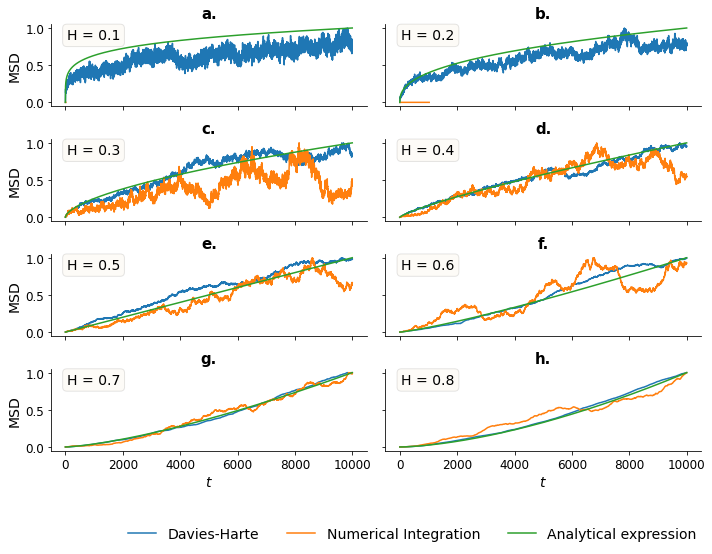

In [8]:
fig, ax = plt.subplots(int(len(h_s)/2), 2, sharex = True, sharey = True, figsize = (10,7))
col = 0
row = 0
panels = ["a.", "b.", "c.", "d.", "e.", "f.", "g.", "h."]
for i, h in enumerate(h_s):
    df_dh = ut.read_hdf5_data(data_path + f"fBm_dh-h-{h}-100.hdf5").set_index("t")
    df_in = ut.read_hdf5_all(h, data_path, 1, 10).set_index("t")
    msd_dh = fbms.msd(df_dh)
    msd_in = fbms.msd(df_in)
    
    t = df_in.index
    msd_anal = t**(2*h)
    msd_anal = msd_anal/max(msd_anal)
    
    axi = ax[row][col]

    axi.plot(t,msd_dh, label = "Davies-Harte")
    axi.plot(t,msd_in, label = "Numerical Integration")
    axi.plot(t,msd_anal, label = "Analytical expression")
    axi.set_title(panels[i])
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
    axi.text(0.05, 0.95, f"H = {h}", transform=axi.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    if row == len(h_s)/2 - 1: axi.set_xlabel("$t$")

    if col == 1: row += 1; col = 0
    else: col += 1; axi.set_ylabel("MSD")


fig.tight_layout()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, -0.03), ncol = len(h_s)/2)
